# Dense probe


### Setup

Activate `spikinterf` venv

In [2]:
# SETUP PACKAGES
%load_ext autoreload
%autoreload 2
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import spikeinterface as si
import yaml 

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")


# SET PATHS
PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/spikebias/"

os.chdir(PROJ_PATH)

from src.nodes.utils import get_config
from src.nodes.validation import noise

# SETUP PARAMETERS
DURATION = 1.01
CHANNEL_IDS = [30]
SF = 20000  # sampling frequency
ID_PERIOD_SILI = 51  # 10, 7
ID_PERIOD_VIVO = 0
L5_SITE_SILI = 0
L5_SITE_VIVO = 6

# vivo
data_conf_vivo, param_conf_h_vivo = get_config("vivo_horvath", "probe_2").values() 
PREP_PATH_vivo = data_conf_vivo["preprocessing"]["full"]["output"]["trace_file_path"]

# silico
data_conf_sili, param_conf_sili = get_config("dense_spont", "probe_2").values()
PREP_PATH_sili = data_conf_sili["preprocessing"]["full"]["output"]["trace_file_path"]

# figure parameters
SAVE_FIG = False
SAVE_FIG_DATA = False
LOAD_FIG_DATA = True

with open("./conf/figures.yml", "r", encoding="utf-8") as yaml_file:
    fig_data_paths = yaml.load(yaml_file, Loader=yaml.FullLoader)


# FIGURE SETTINGS
FIG_SIZE = (0.9, 0.7)
# colors
COLOR_HV = [0.3, 0.3, 0.3]
COLOR_HS = np.array([26, 152, 80]) / 255

# axes
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 6  # 5-7 with Nature neuroscience as reference
plt.rcParams["lines.linewidth"] = 0.5
plt.rcParams["axes.linewidth"] = 0.5 #1
plt.rcParams["axes.spines.top"] = False
plt.rcParams["xtick.major.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["xtick.minor.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["ytick.major.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["ytick.minor.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["xtick.major.size"] = 3.5 * 1.1
plt.rcParams["xtick.minor.size"] = 2 * 1.1
plt.rcParams["ytick.major.size"] = 3.5 * 1.1
plt.rcParams["ytick.minor.size"] = 2 * 1.1
# legend
savefig_cfg = {"transparent":True, "dpi":300}
legend_cfg = {"frameon": False, "handletextpad": 0.1}
tight_layout_cfg = {"pad": 0.5}
LG_FRAMEON = False              # no legend frame

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2024-12-13 12:38:47,075 - root - utils.py - get_config - INFO - Reading experiment config.
2024-12-13 12:38:47,098 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-12-13 12:38:47,099 - root - utils.py - get_config - INFO - Reading experiment config.
2024-12-13 12:38:47,131 - root - utils.py - get_config - INFO - Reading experiment config. - done


### Get sites in cortex

In [3]:
if SAVE_FIG_DATA:
    
    # load Recording
    Recording_sili = si.load_extractor(PREP_PATH_sili)
    traces_sili = Recording_sili.get_traces()

    # get a site in layer 5
    layers_sili = Recording_sili.get_property("layers")

### Parameterize

In [11]:
LAYER = "L5"
YLIM = (-500, 350)

### Model

In [4]:
# get data
if SAVE_FIG_DATA:
    
    # plot
    ID_PERIOD_SILI = 10 #20  # 15  # 31, 18, 50  # 50, 7
    L5_SITE_SILI = 10  # 10, 1, 5

    # set period
    # get trace
    L5_site = np.where(layers_sili == LAYER)[0][L5_SITE_SILI]

    # calculate one seconde period
    one_sec_period = np.arange(
        (ID_PERIOD_SILI - 1) * SF, ID_PERIOD_SILI * SF, 1
    )
    # save figure data
    fig_data = traces_sili[one_sec_period, L5_site]    
    np.save(fig_data_paths["fig2d_compo_silico_horv"], fig_data)
    
elif LOAD_FIG_DATA:
    fig_data = np.load(fig_data_paths["fig2d_compo_silico_horv"])
    print("loaded figure data")

loaded figure data


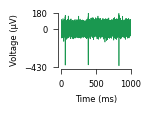

In [5]:
# plot
fig, ax = plt.subplots(1, 1, figsize=FIG_SIZE)
ax.plot(fig_data, color=COLOR_HS)

# legend
ax.spines[["right", "top"]].set_visible(False)
ax.set_ylabel("Voltage (\u03bcV)")
ax.set_xlabel("Time (ms)")
ax.set_xticks([0, SF / 2, SF], [0, 500, 1000])
ax.set_xlim([0, SF])
ax.set_yticks([-430, 0, 180])
ax.set_ylim([-430, 180])

# disconnected
ax.spines["bottom"].set_position(("axes", -0.05))
ax.yaxis.set_ticks_position("left")
ax.spines["left"].set_position(("axes", -0.05))

# save figure
if SAVE_FIG:
    plt.savefig("figures/0_validation/1_components/fig2d_compo_silico_horv.svg")

In [6]:
# get data

# background noise (min(MAD) over segments of 1 sec) here
if SAVE_FIG_DATA:
    wind_end = int(np.floor(len(traces_sili)/SF))
    bkg_noise = noise.measure_trace_noise(traces_sili[one_sec_period, L5_site], SF, wind_end)
    np.save(fig_data_paths["fig2d_compo_silico_horv_bkg_noise"], bkg_noise)
elif LOAD_FIG_DATA:
    bkg_noise = np.load(fig_data_paths["fig2d_compo_silico_horv_bkg_noise"])
    print("loaded figure data")
    
print("nb of 1-sec windows:", len(bkg_noise))
print("Background noise level (min MAD over windows):", min(bkg_noise))

loaded figure data
nb of 1-sec windows: 1175
Background noise level (min MAD over windows): 29.4982


### In vivo

In [7]:
if SAVE_FIG_DATA:
    # plot
    ## to find max
    # L5_site_vivo = np.where(layers_vivo == LAYER)[0]
    # x = traces_vivo[:, L5_site_vivo]
    # ind = np.unravel_index(np.argmax(x, axis=None), x.shape)
    L5_SITE = 79  # 24  # 1
    SAMPLE_START = 15868410

    # get traces
    Recording_vivo = si.load_extractor(PREP_PATH_vivo)
    traces_vivo = Recording_vivo.get_traces()

    # get a site in layer 5
    layers_vivo = Recording_vivo.get_property("layers")
    L5_site_vivo = np.where(layers_vivo == LAYER)[0][L5_SITE]

    # calculate one seconde period
    one_sec_period = np.arange(SAMPLE_START, SAMPLE_START + SF, 1)
    
    # save figure data
    fig_data = traces_vivo[one_sec_period, L5_site_vivo]
    np.save(fig_data_paths["fig2e_compo_vivo_horv"], fig_data)

elif LOAD_FIG_DATA:
    fig_data = np.load(fig_data_paths["fig2e_compo_vivo_horv"])
    print("loaded figure data")

loaded figure data


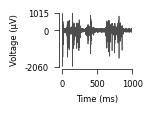

In [8]:
# plot
fig, ax = plt.subplots(1, 1, figsize=FIG_SIZE)

ax.plot(fig_data, color=COLOR_HV)

# legend
ax.spines[["right", "top"]].set_visible(False)
ax.set_ylabel("Voltage (\u03bcV)")
ax.set_xlabel("Time (ms)")
ax.set_xticks([0, SF / 2, SF], [0, 500, 1000])
ax.set_xlim([0, SF])
ax.set_yticks([-2060, 0, 1015], [-2060, 0, 1015])
ax.set_ylim([-2060, 1015])

# disconnected
ax.spines["bottom"].set_position(("axes", -0.05))
ax.yaxis.set_ticks_position("left")
ax.spines["left"].set_position(("axes", -0.05))

# save
if SAVE_FIG:
    plt.savefig("figures/0_validation/1_components/fig2e_compo_vivo_horv.svg")

In [9]:
# get data

# background noise (min(MAD) over segments of 1 sec) here
if SAVE_FIG_DATA:
    wind_end = int(np.floor(len(traces_vivo)/SF))
    bkg_noise = noise.measure_trace_noise(fig_data, SF, wind_end)
    np.save(fig_data_paths["fig2e_compo_vivo_horv_bkg_noise"], bkg_noise)
elif LOAD_FIG_DATA:
    bkg_noise = np.load(fig_data_paths["fig2e_compo_vivo_horv_bkg_noise"])
    print("loaded figure data")
    
print("nb of 1-sec windows:", len(bkg_noise))
print("Background noise level (min MAD over windows):", min(bkg_noise))

loaded figure data
nb of 1-sec windows: 3688
Background noise level (min MAD over windows): 79.58119
